In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tree_importer import tree_importer
from quality_cuts import quality_cuts
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.font_manager import FontProperties

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import gc
import matplotlib as mpl
import random

# check what dependencies do u need

from scipy.stats import binned_statistic as b_s
from scipy.stats import linregress
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy.stats import chisquare
from scipy.optimize import curve_fit

In [2]:
plt.rcParams.update({'font.size': 25})

In [3]:
df_original = tree_importer('/home/olha/CBM/dataset/10k_events_PFSimplePlainTree.root','PlainTree')


gc.collect()

2072

In [4]:
new_labels= ['chi2geo', 'chi2primneg', 'chi2primpos', 'chi2topo', 'cosineneg',
       'cosinepos', 'cosinetopo', 'distance', 'eta', 'l', 'ldl',
       'mass', 'p', 'pT', 'phi', 'px', 'py', 'pz', 'rapidity',
             'x', 'y', 'z', 'daughter1id', 'daughter2id', 'isfrompv', 'pid', 'issignal']


df_original.columns = new_labels


sgnal = df_original[df_original['issignal']==1]
bg = df_original[df_original['issignal']==0]

In [5]:
len(sgnal)

13348

In [6]:
len(bg)

48822740

In [13]:
 len(bg) *100 / (len(bg) + len(sgnal))

99.972667753404

In [9]:
signal = quality_cuts(sgnal)
background = quality_cuts(bg)

mpl.rc('figure', max_open_warning = 0)

In [10]:
len(signal)

13096

In [11]:
len(background)

23986377

In [14]:
100 - len(background) * 100 / (len(background) + len(signal))

0.05456786488603882

In [6]:
non_log_x = ['cosineneg', 'cosinepos', 'cosinetopo']
log_x = ['chi2geo', 'chi2primneg', 'chi2primpos', 'ldl', 'distance']

In [7]:
new_log_x = []

for feat in log_x:
    signal[feat+'_log'] = np.log(signal[feat])
    background[feat+'_log'] = np.log(background[feat])
    
    new_log_x.append(feat+'_log')

In [8]:
features = non_log_x + new_log_x
features

['cosineneg',
 'cosinepos',
 'cosinetopo',
 'chi2geo_log',
 'chi2primneg_log',
 'chi2primpos_log',
 'ldl_log',
 'distance_log']

In [9]:
def lin(x, p1, p2):
    return p1*x + p2

In [10]:
def gaus(x,k, b,a,x0,sigma):
    return k*x+b+a*np.exp(-(x-x0)**2/(2*sigma**2))

In [59]:
def profile_plot_func(df,variable_xaxis,variable_yaxis, sign, pdf_key, func):
    
    if sign == 1:
        keyword = 'signal'
    if sign == 0:
        keyword = 'background'
        
    if variable_xaxis=='mass':
        df = df[(df['mass'] < 1.13) & (df['mass'] > 1.1)]
        unit = r'mass, $ \frac{GeV}{c^2}$'
        
    if variable_xaxis=='pT':
        df = df[df['pT'] < 3]
        unit = r'pT, $ \frac{GeV}{c}$'

    fig, axs = plt.subplots(figsize=(20, 15))
     
    bin_means, bin_edges, binnumber = b_s(df[variable_xaxis],df[variable_yaxis], statistic='mean', bins=25)
    bin_std, bin_edges, binnumber = b_s(df[variable_xaxis],df[variable_yaxis], statistic='std', bins=25)
    bin_count, bin_edges, binnumber = b_s(df[variable_xaxis],df[variable_yaxis], statistic='count',bins= 25)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    
    nan_ind = np.where(np.isnan(bin_means))
    bin_centers = np.delete(bin_centers, nan_ind)
    bin_means = np.delete(bin_means, nan_ind)
    
    plt.errorbar(x=bin_centers, y=bin_means, yerr=(bin_std/np.sqrt(bin_count)), linestyle='none', marker='.',mfc='red', ms=10)
    
    x = np.linspace(1.1,1.13,1000)
    # Fitting a line on the data 
    
    if func == lin:
    
        popt, pcov = curve_fit(func, bin_centers, bin_means)
        residuals = bin_means- func(bin_centers, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((bin_means-np.mean(bin_means))**2)
        r_squared = 1 - (ss_res / ss_tot)
        chi_2 = chisquare(bin_means, popt[0]*bin_centers+ popt[1])[1]

        plt.plot(x , func(x, *popt), 'b', label='fitted line'+
             " with $\chi^2$ :{0:.4g}".format(chi_2)+'\n $R^2$-squared: {0:.4g}'.format(r_squared)  +'\n and the p values are \n [ {0:.4g}'.format(popt[0])+'  {0:.4g}'.format(popt[1])+']'+
            '\n $p1 \cdot x+p2$')
        
    if func == gaus: 
        popt,pcov = curve_fit(gaus,bin_centers, bin_means,p0=[2, 1.5, 2, 1.115, 0.0025])
        residuals = bin_means- gaus(bin_centers,*popt)
        chi_2 = chisquare(bin_means, gaus(bin_centers,*popt))[1]
        
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((bin_means-np.mean(bin_means))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        
        plt.plot(x,gaus(x,*popt),'b', label='fitted line'+
         " with $\chi^2$ :{0:.4g}".format(chi_2)+'\n $R^2$-squared: {0:.5g}'.format(r_squared) + 
         '\n Gaussian fit: \n A : {0:.4g}'.format(popt[2]) + '\n $\mu$ : {0:.5g}'.format(abs(popt[3])) +
        '\n $\sigma$ : {0:.5g}'.format(popt[4]))


         


    
    print("Params: ", popt)
    
    
    plt.rcParams['font.size'] = '25'
    for label in(axs.get_xticklabels() + axs.get_yticklabels()):
        label.set_fontsize(25)
  

    


    plt.legend(fontsize=25)
    plt.title('Mean of ' +variable_yaxis+ ' plotted versus bin centers of '+variable_xaxis+ \
              '('+keyword+')', fontsize=25)
    plt.xlabel(unit, fontsize=25)
    plt.ylabel("Mean of each bin with the SEM ($\dfrac{bin\ std}{\sqrt{bin\ count}}$) of bin", fontsize=25)

    
    plt.vlines(x=1.115683,ymin=bin_means.min(),ymax=bin_means.max(), color='r', linestyle='-')

    
    fig.tight_layout()
    plt.savefig(pdf_key,format='pdf')

In [60]:
sign_bgr_mass_pdf = PdfPages('sign_bgr_mass.pdf')

Params:  [-0.04289544  1.04590159]


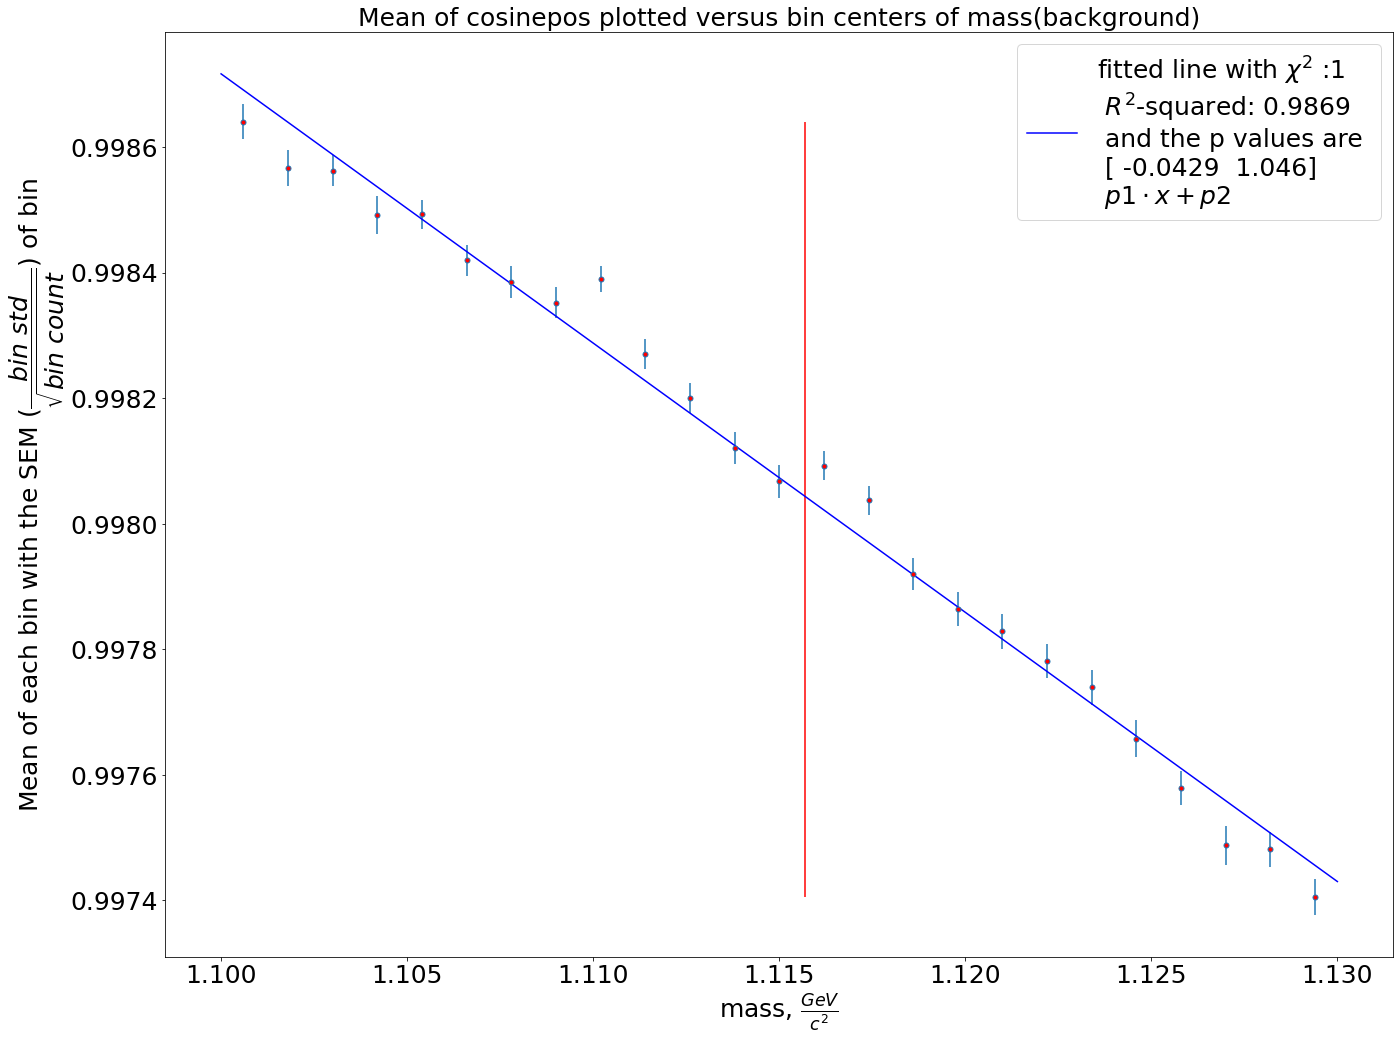

In [61]:
profile_plot_func(background,'mass','cosinepos', 0, sign_bgr_mass_pdf, lin)

Params:  [-0.39924942  1.41660031]


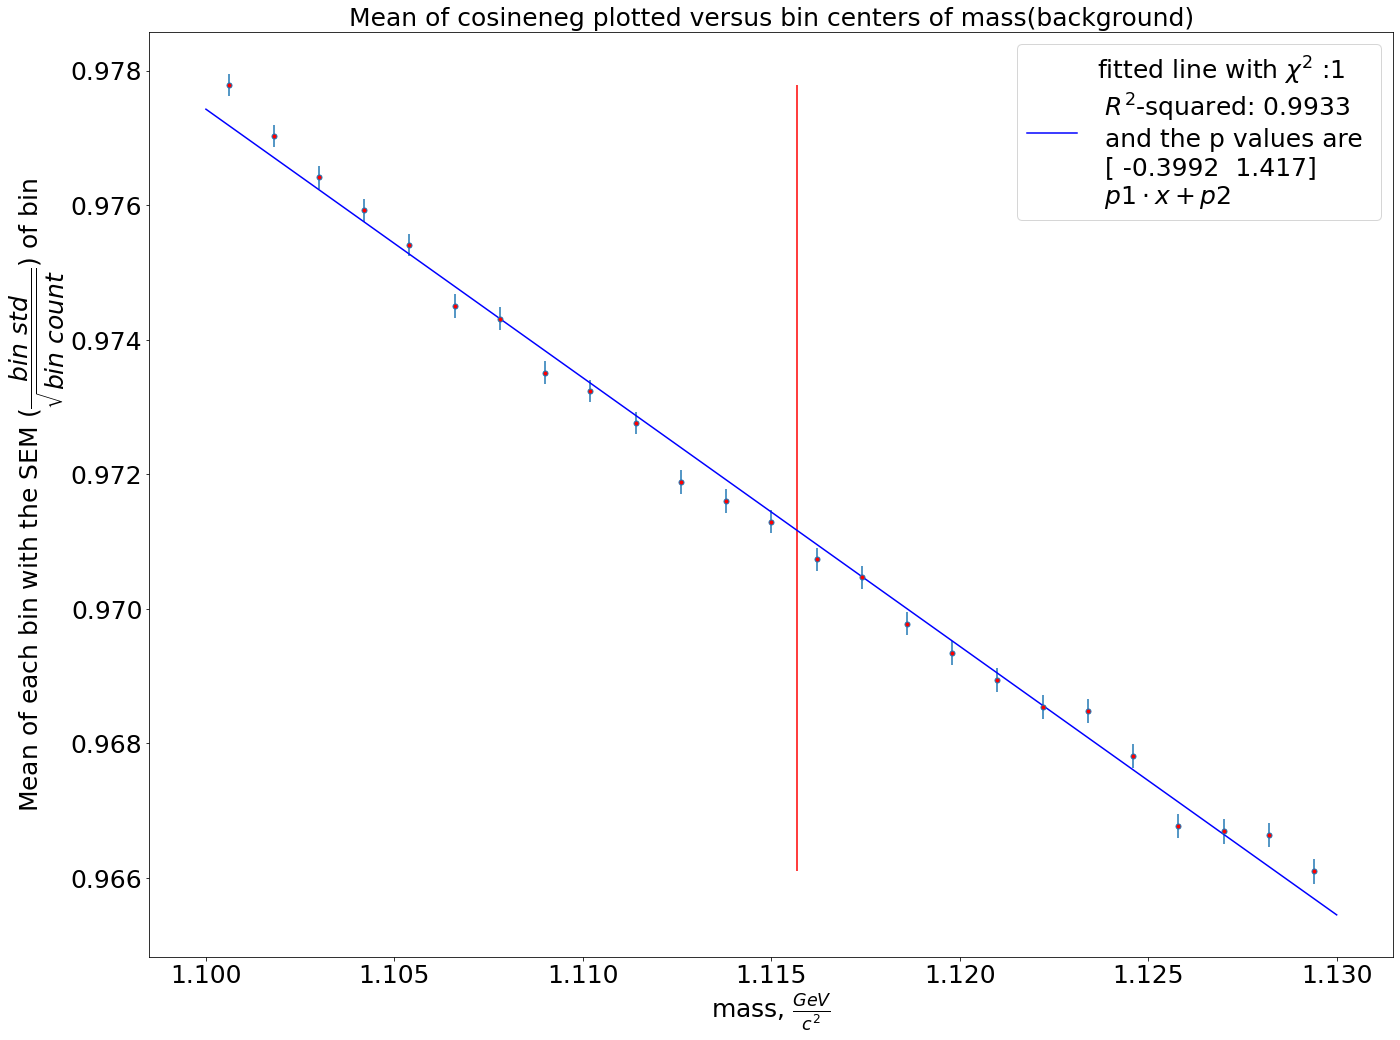

In [62]:
profile_plot_func(background,'mass','cosineneg', 0, sign_bgr_mass_pdf, lin)

Params:  [-0.36111297  1.36796266]


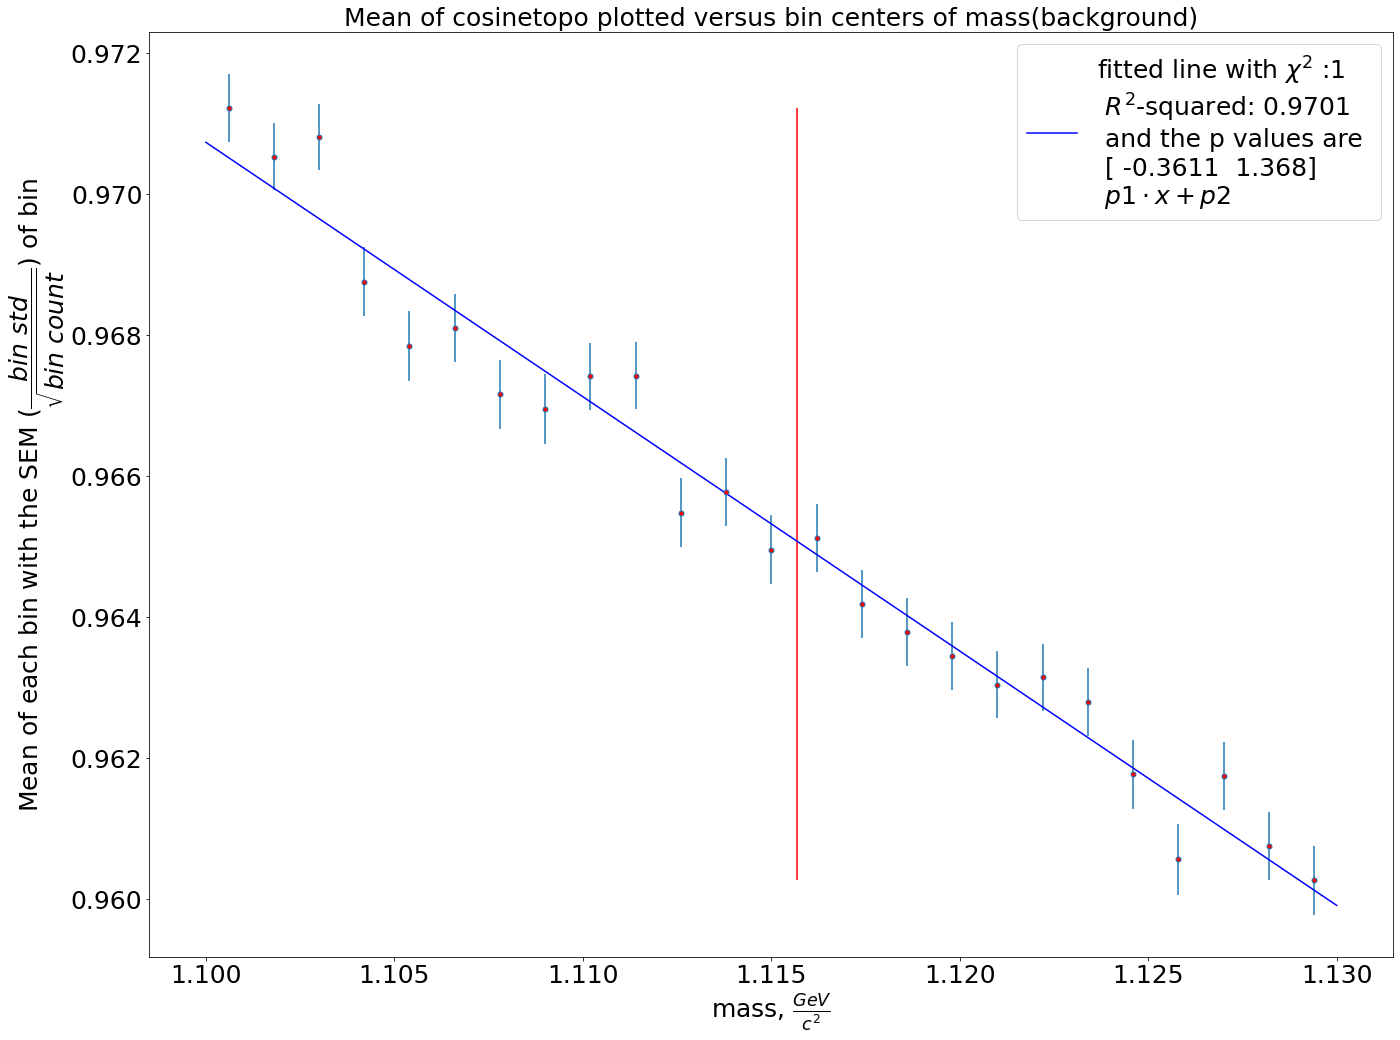

In [63]:
profile_plot_func(background,'mass','cosinetopo', 0, sign_bgr_mass_pdf, lin)

Params:  [1.23105116 0.25601613]


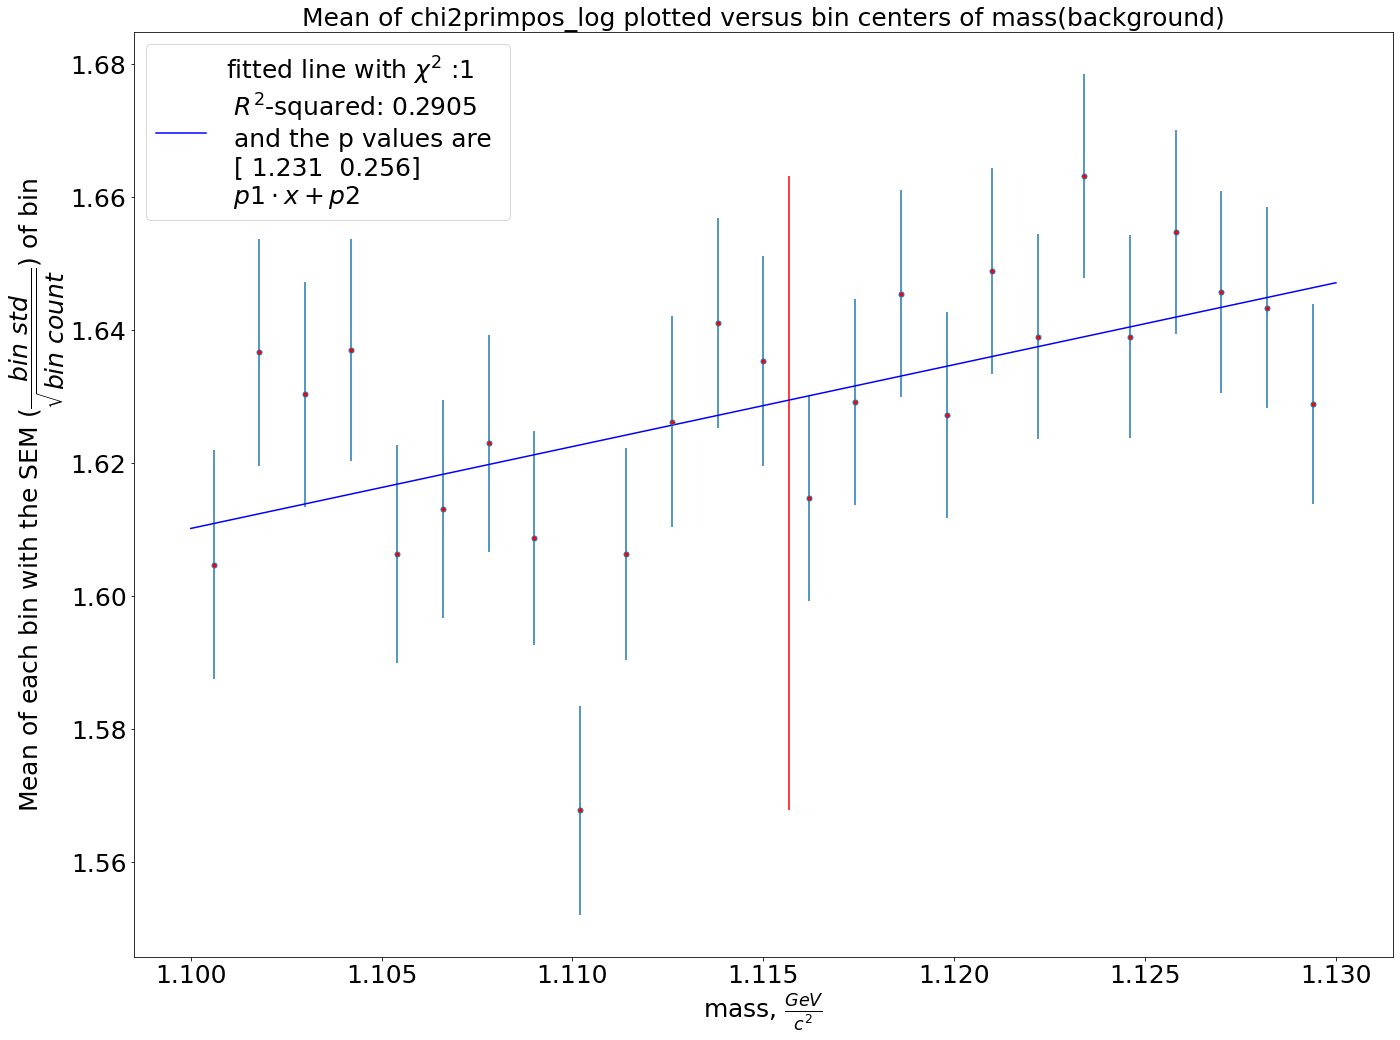

In [64]:
profile_plot_func(background,'mass','chi2primpos_log', 0, sign_bgr_mass_pdf, lin)

Params:  [-2.95824176  6.52612685]


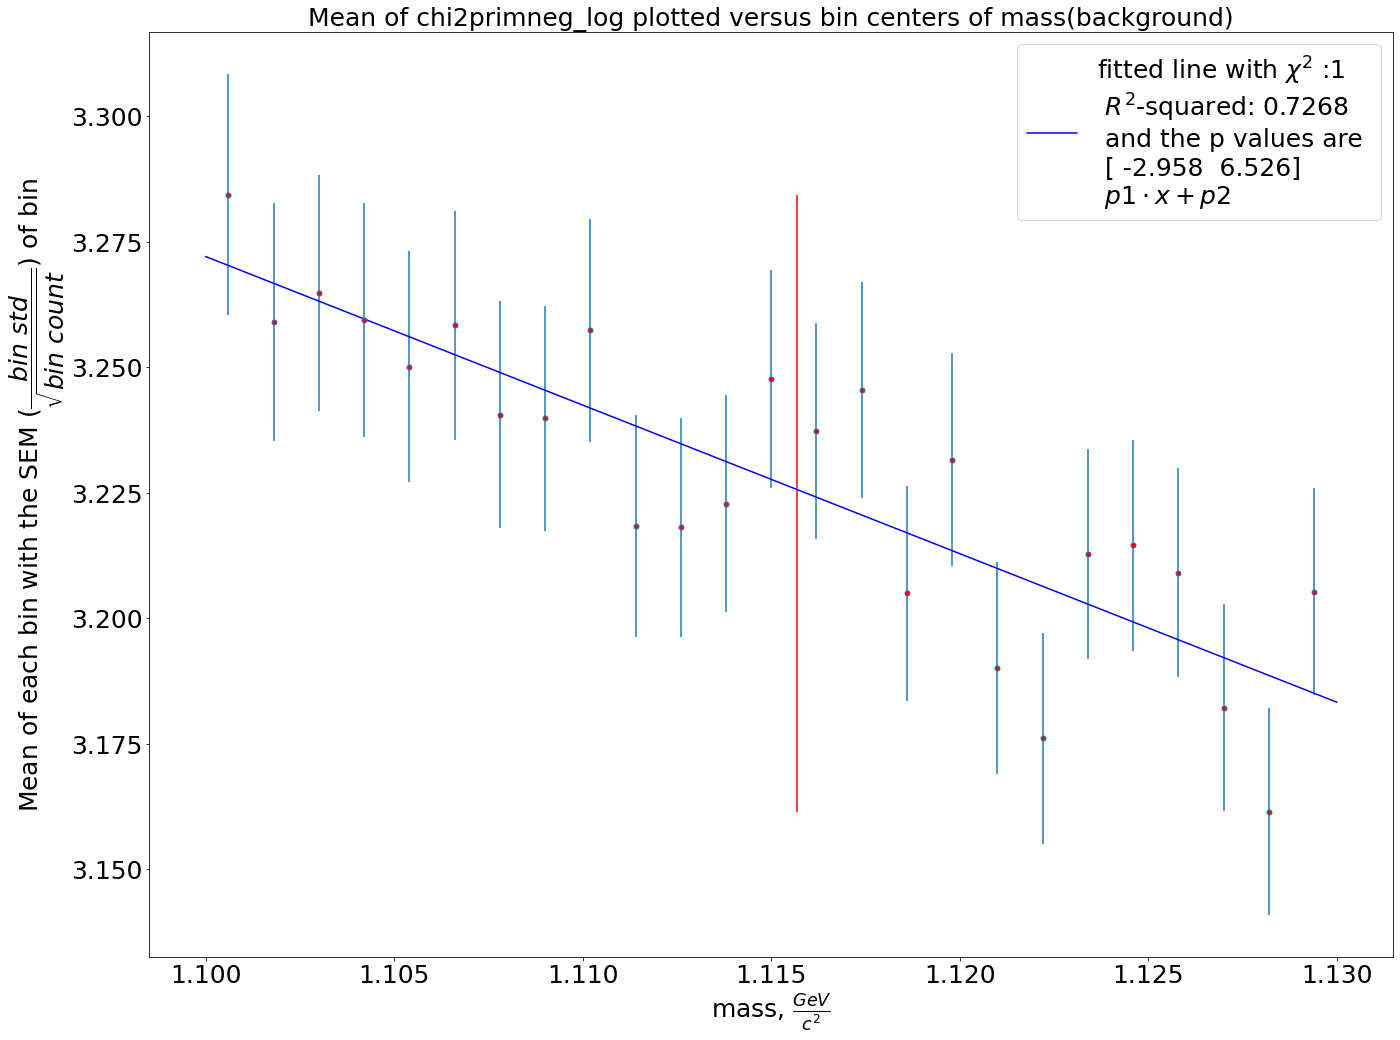

In [65]:
profile_plot_func(background,'mass','chi2primneg_log', 0, sign_bgr_mass_pdf, lin)

Params:  [-5.54929228  7.66694047]


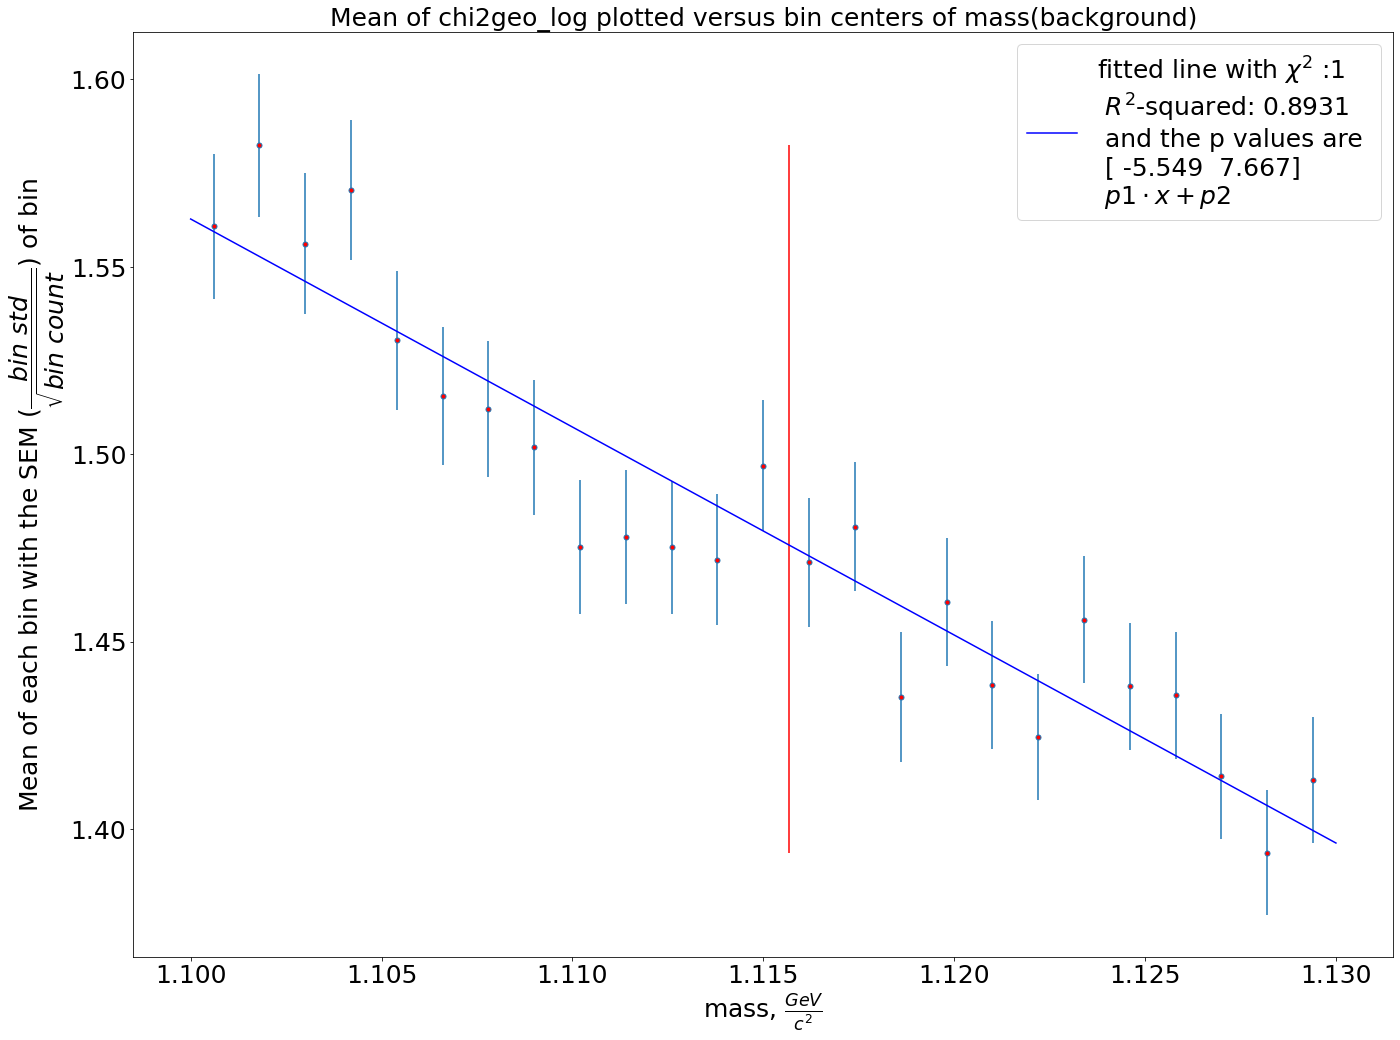

In [66]:
profile_plot_func(background,'mass','chi2geo_log', 0, sign_bgr_mass_pdf, lin)

Params:  [-2.95286281  0.34093766]


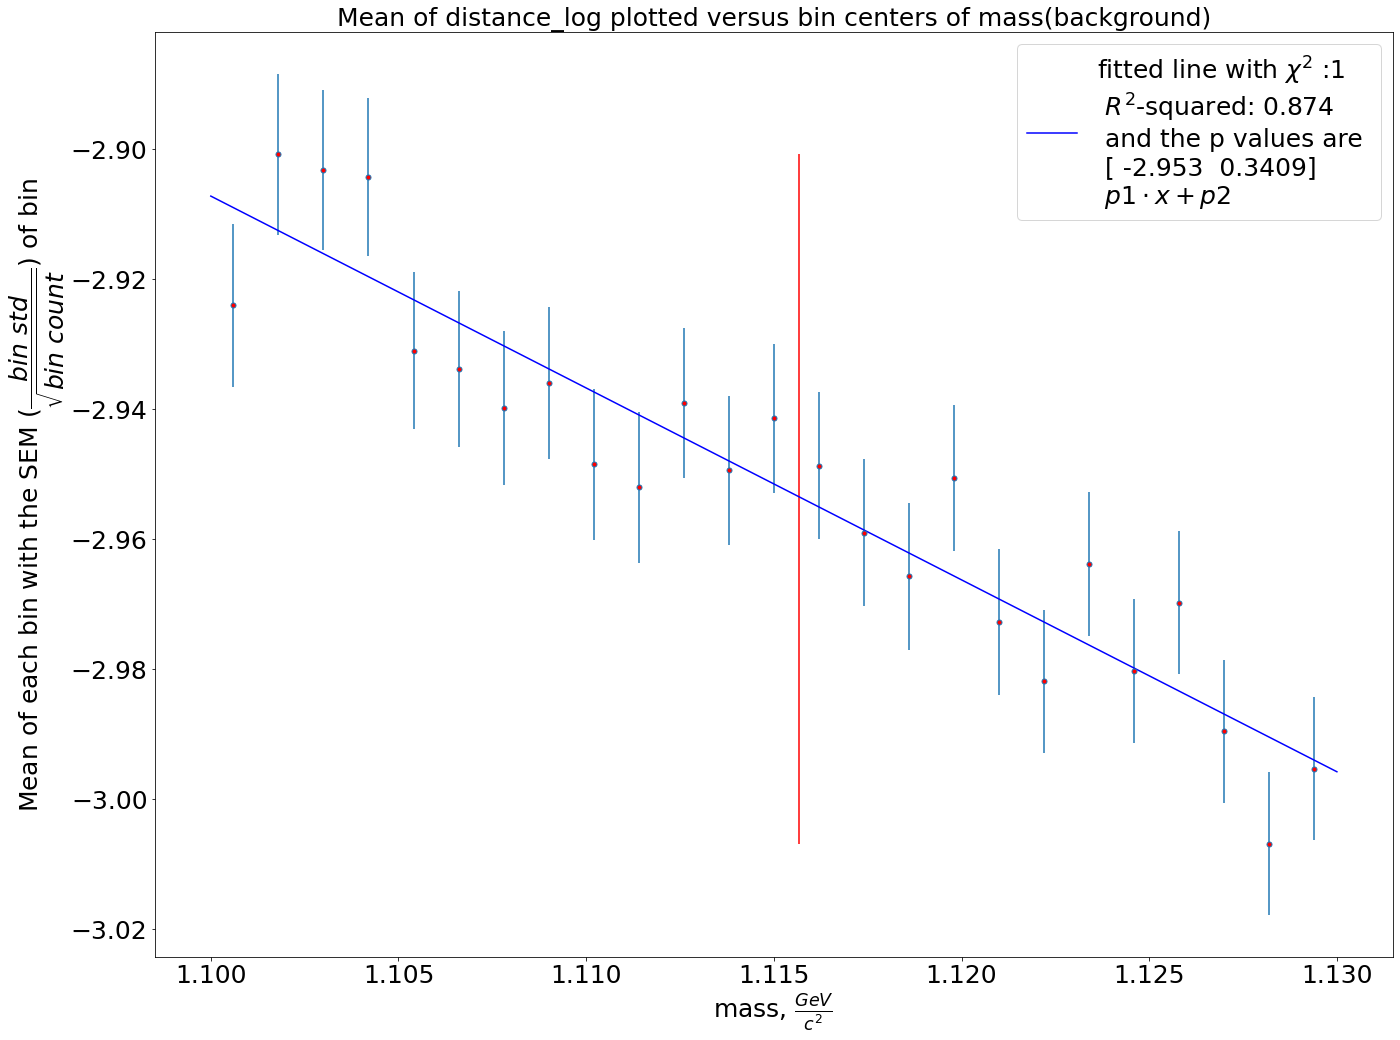

In [67]:
profile_plot_func(background,'mass','distance_log', 0, sign_bgr_mass_pdf, lin)

Params:  [-0.76758528  1.78900935]


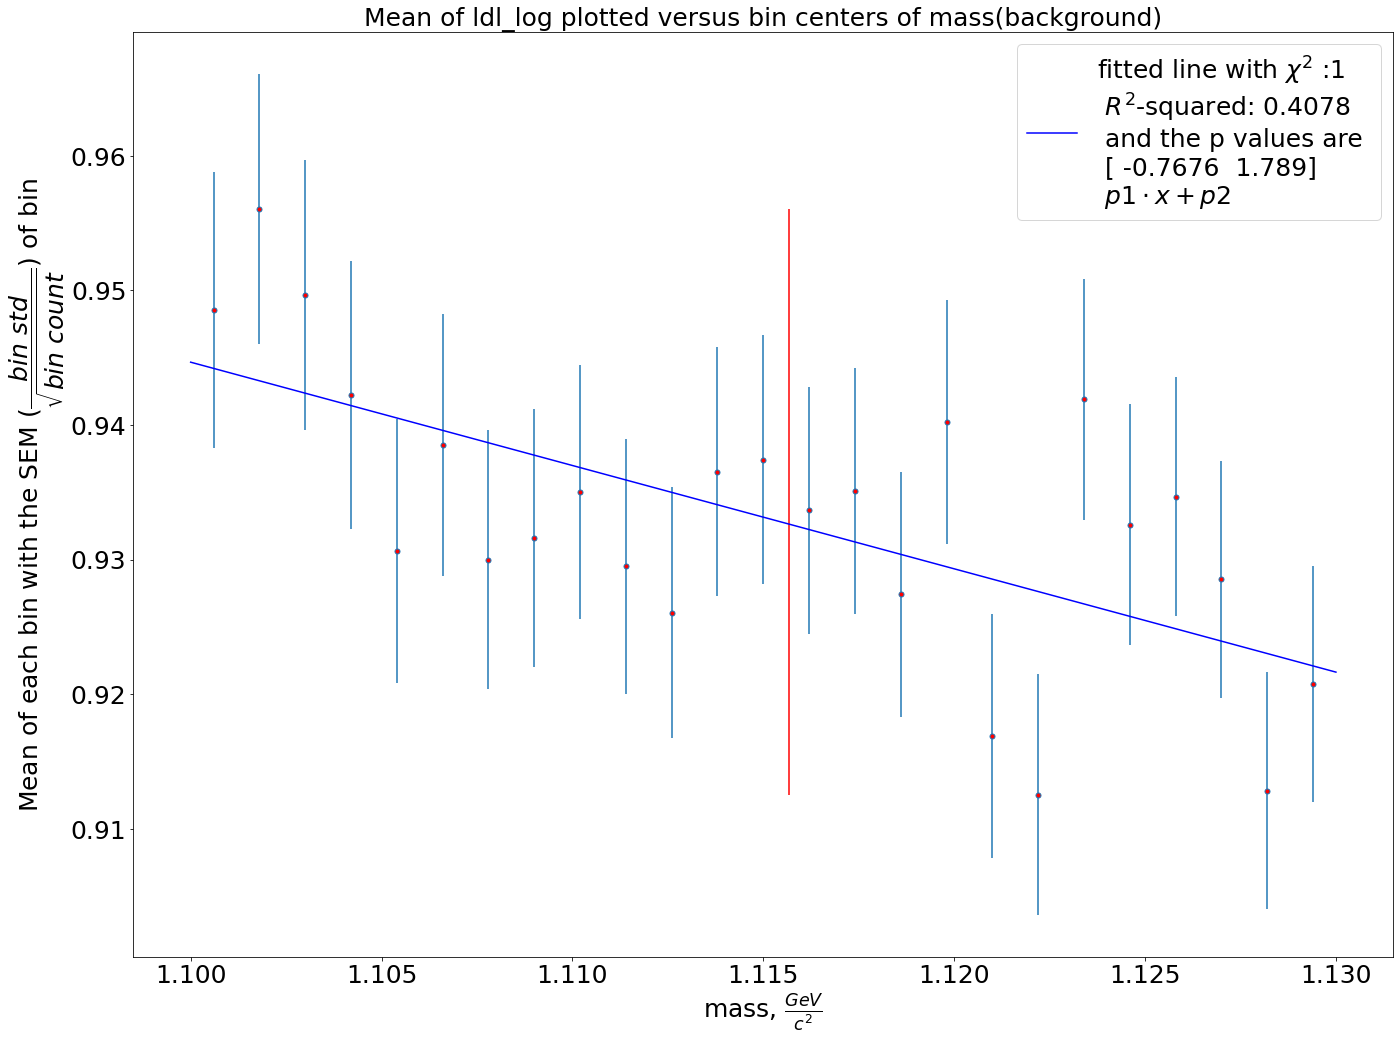

In [68]:
profile_plot_func(background,'mass','ldl_log', 0, sign_bgr_mass_pdf, lin)

In [69]:
# for feat in features:
#     profile_plot_func(signal,'mass',feat, 1, '')

Params:  [-0.07795587  1.06768611]


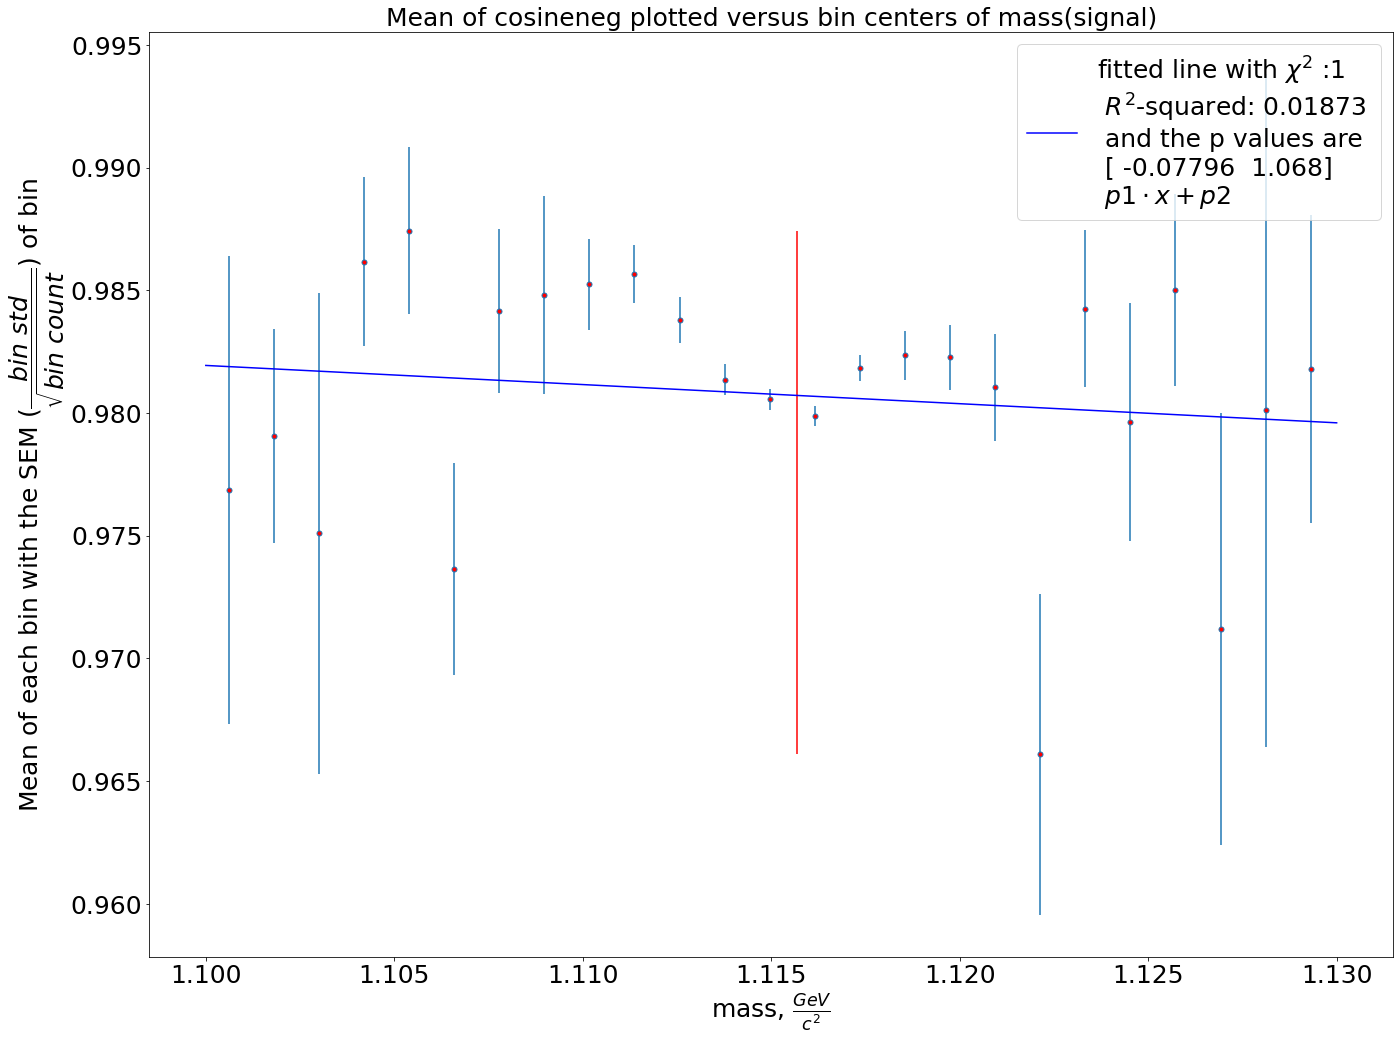

In [70]:
profile_plot_func(signal,'mass','cosineneg', 1, sign_bgr_mass_pdf, lin)

Params:  [-0.0144962   1.01545681]


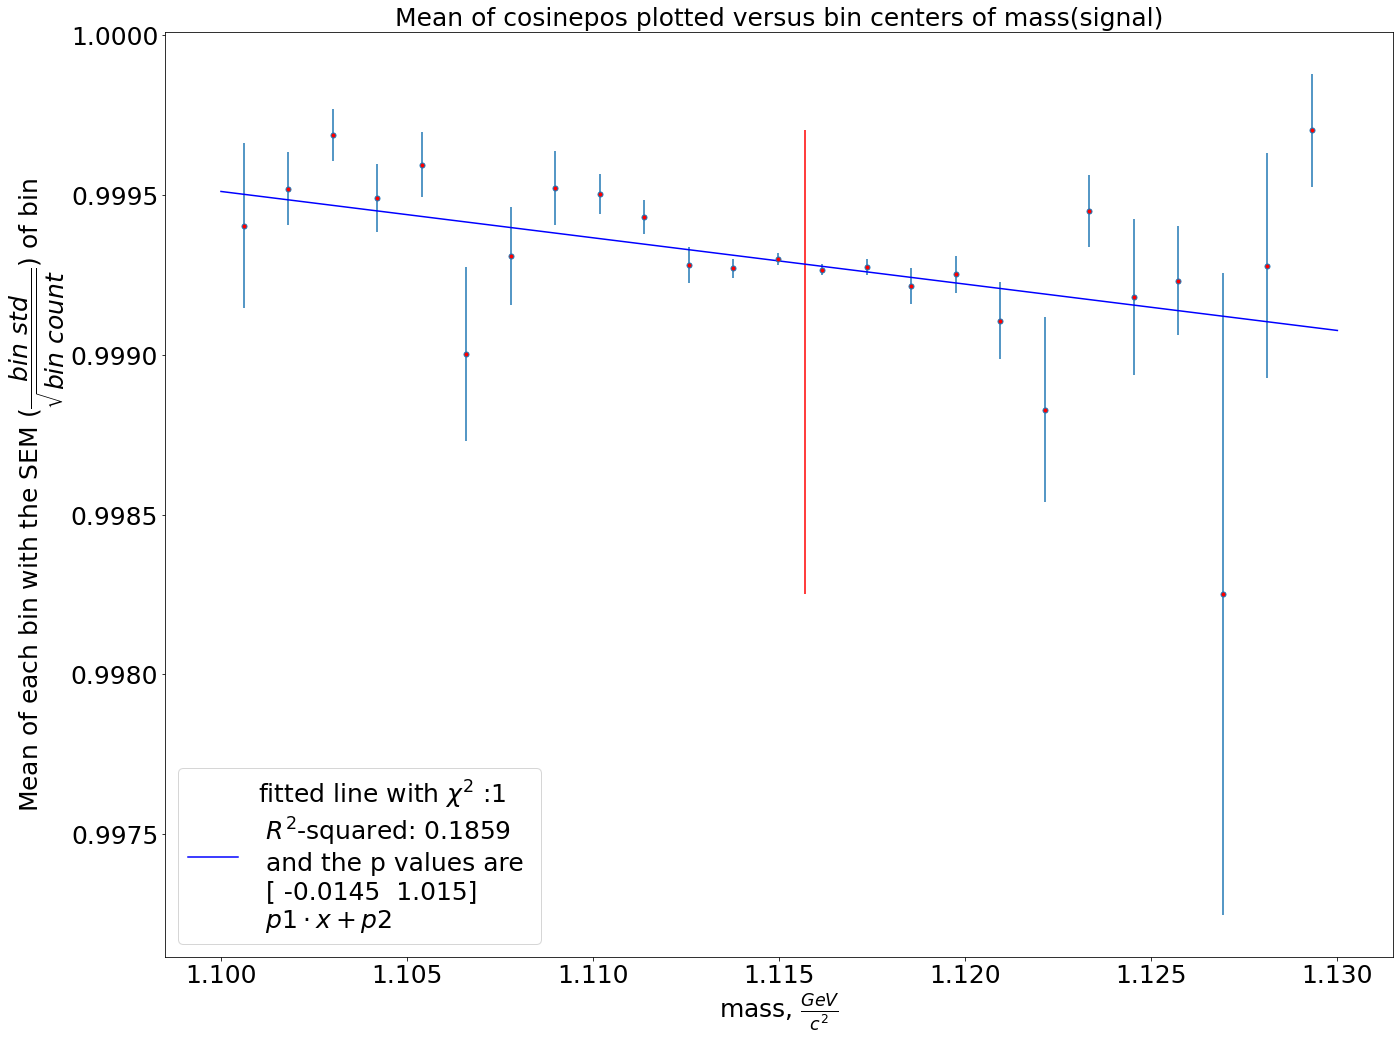

In [71]:
profile_plot_func(signal,'mass','cosinepos', 1, sign_bgr_mass_pdf, lin)

Params:  [0.28960875 0.67401881]


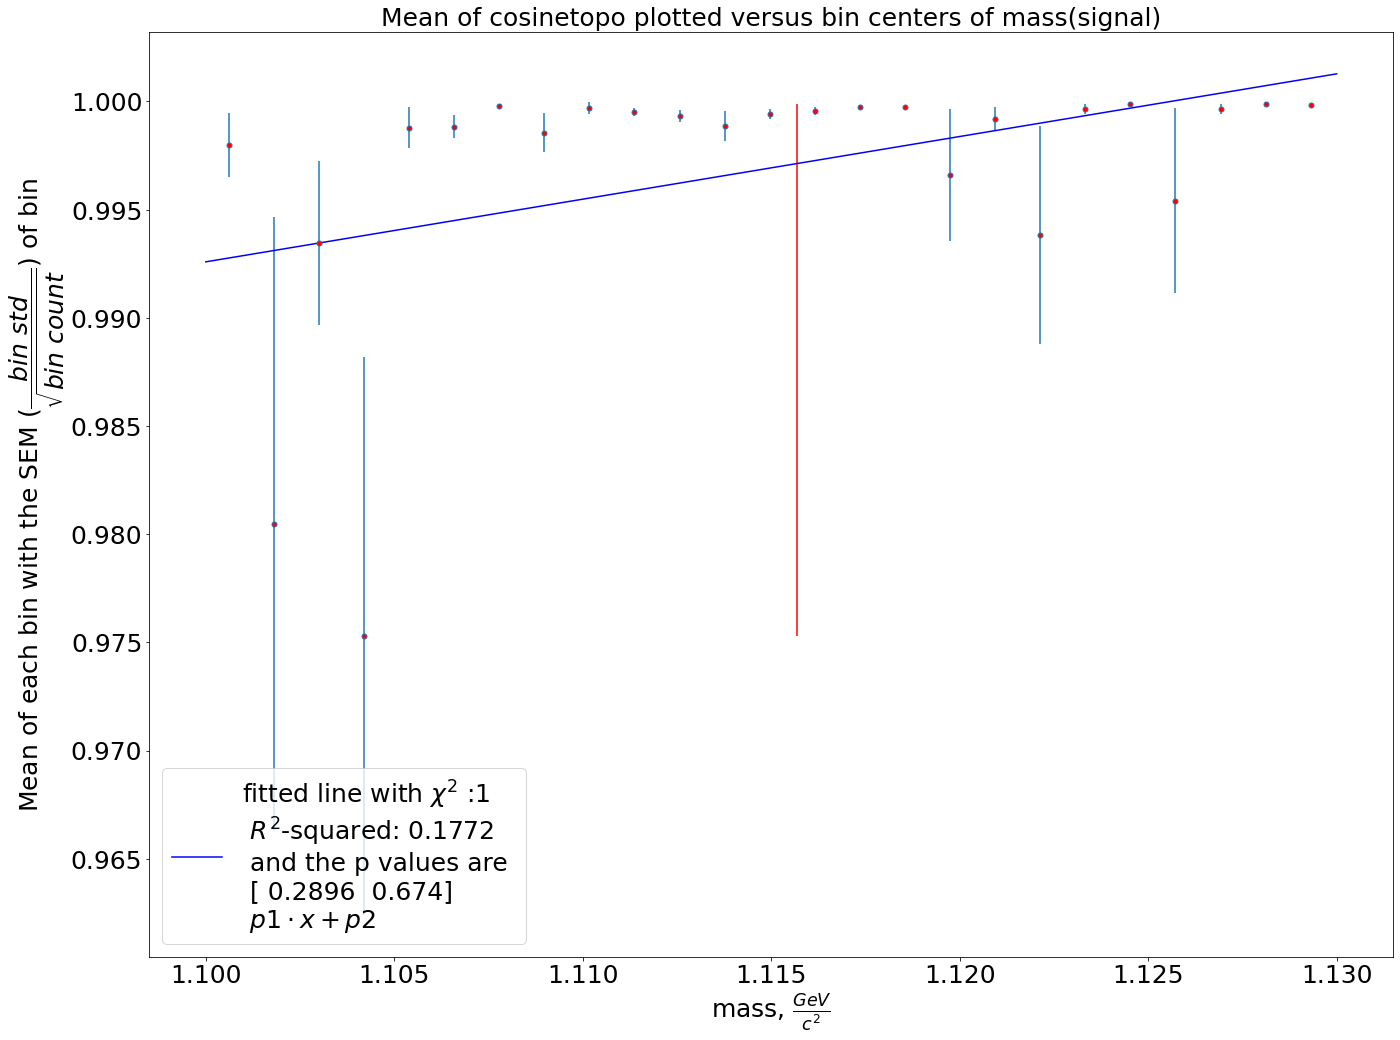

In [72]:
profile_plot_func(signal,'mass','cosinetopo', 1, sign_bgr_mass_pdf, lin)

Params:  [-4.21775903e+01  5.15511729e+01 -5.41170892e+00  1.11614313e+00
 -7.43893139e-03]


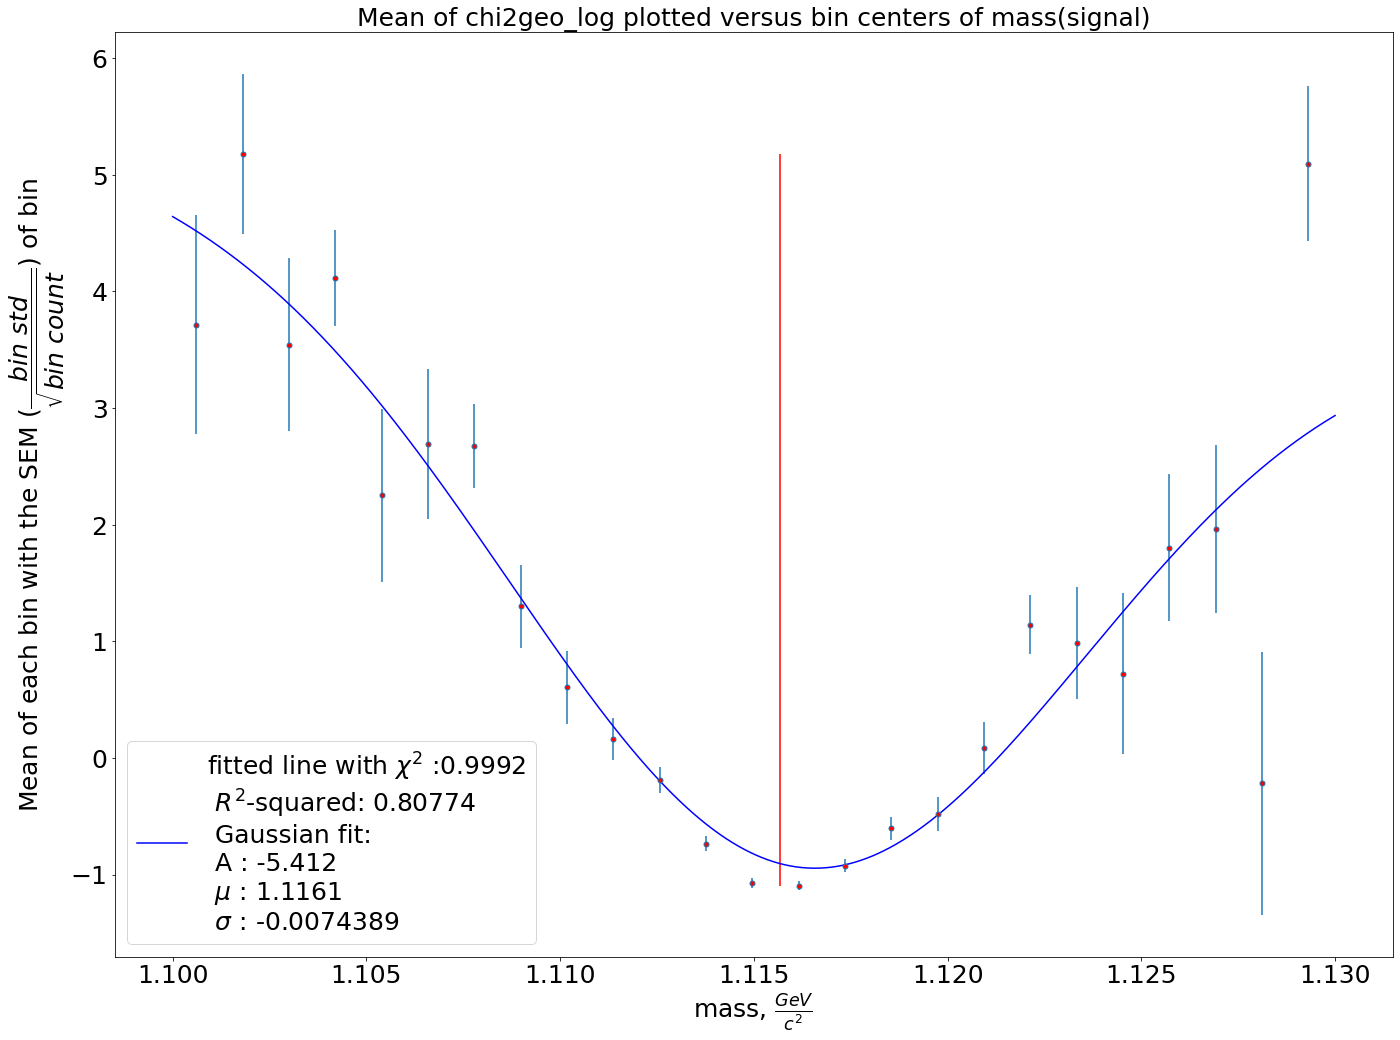

In [73]:
profile_plot_func(signal,'mass','chi2geo_log', 1, sign_bgr_mass_pdf, gaus)

Params:  [ 4.22784272e+01 -3.82366858e+01  1.80015130e+00  1.11553748e+00
  2.79149439e-03]


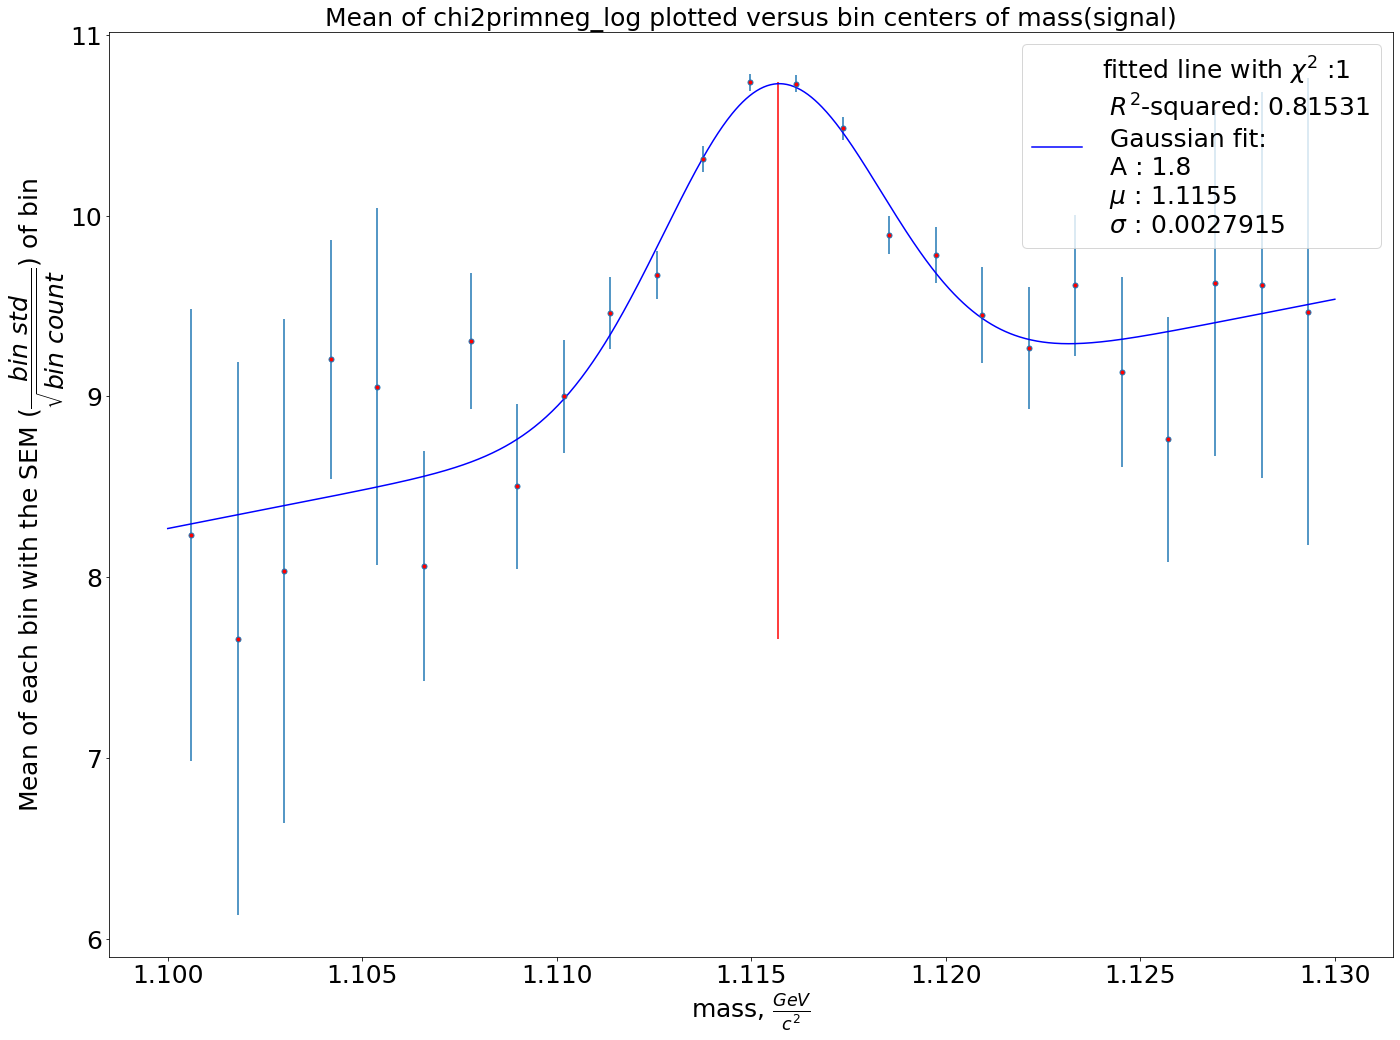

In [74]:
profile_plot_func(signal,'mass','chi2primneg_log', 1, sign_bgr_mass_pdf, gaus)

Params:  [-25.08682761  36.26381952]


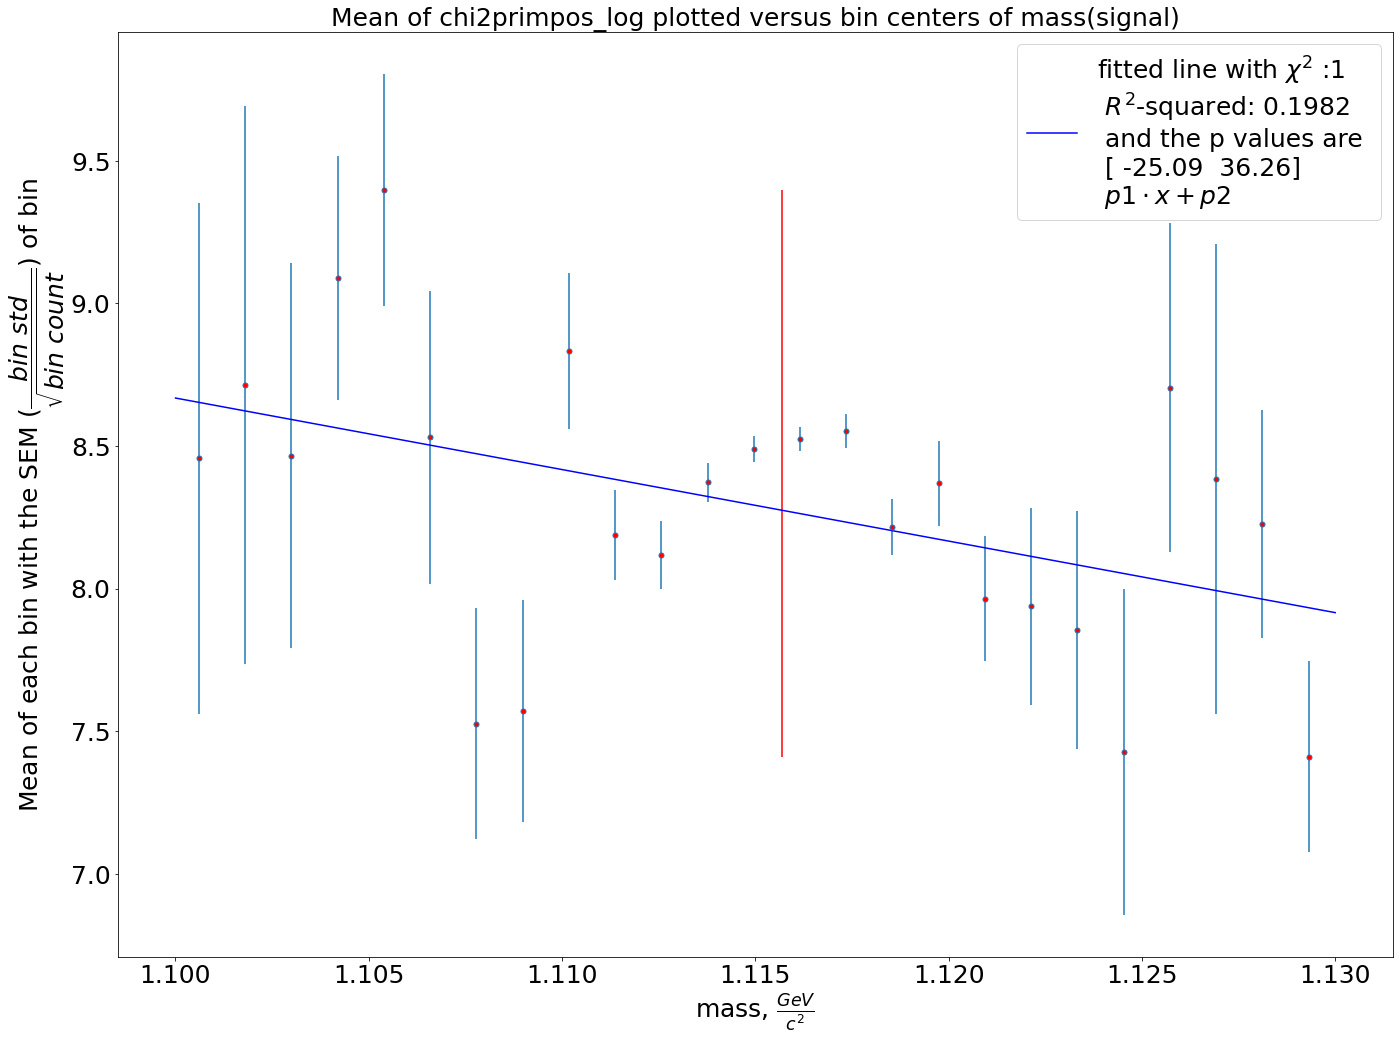

In [75]:
profile_plot_func(signal,'mass','chi2primpos_log', 1, sign_bgr_mass_pdf, lin)

Params:  [ 5.00459322e+01 -5.20160026e+01  1.16039735e+00  1.11490696e+00
  3.41596202e-03]


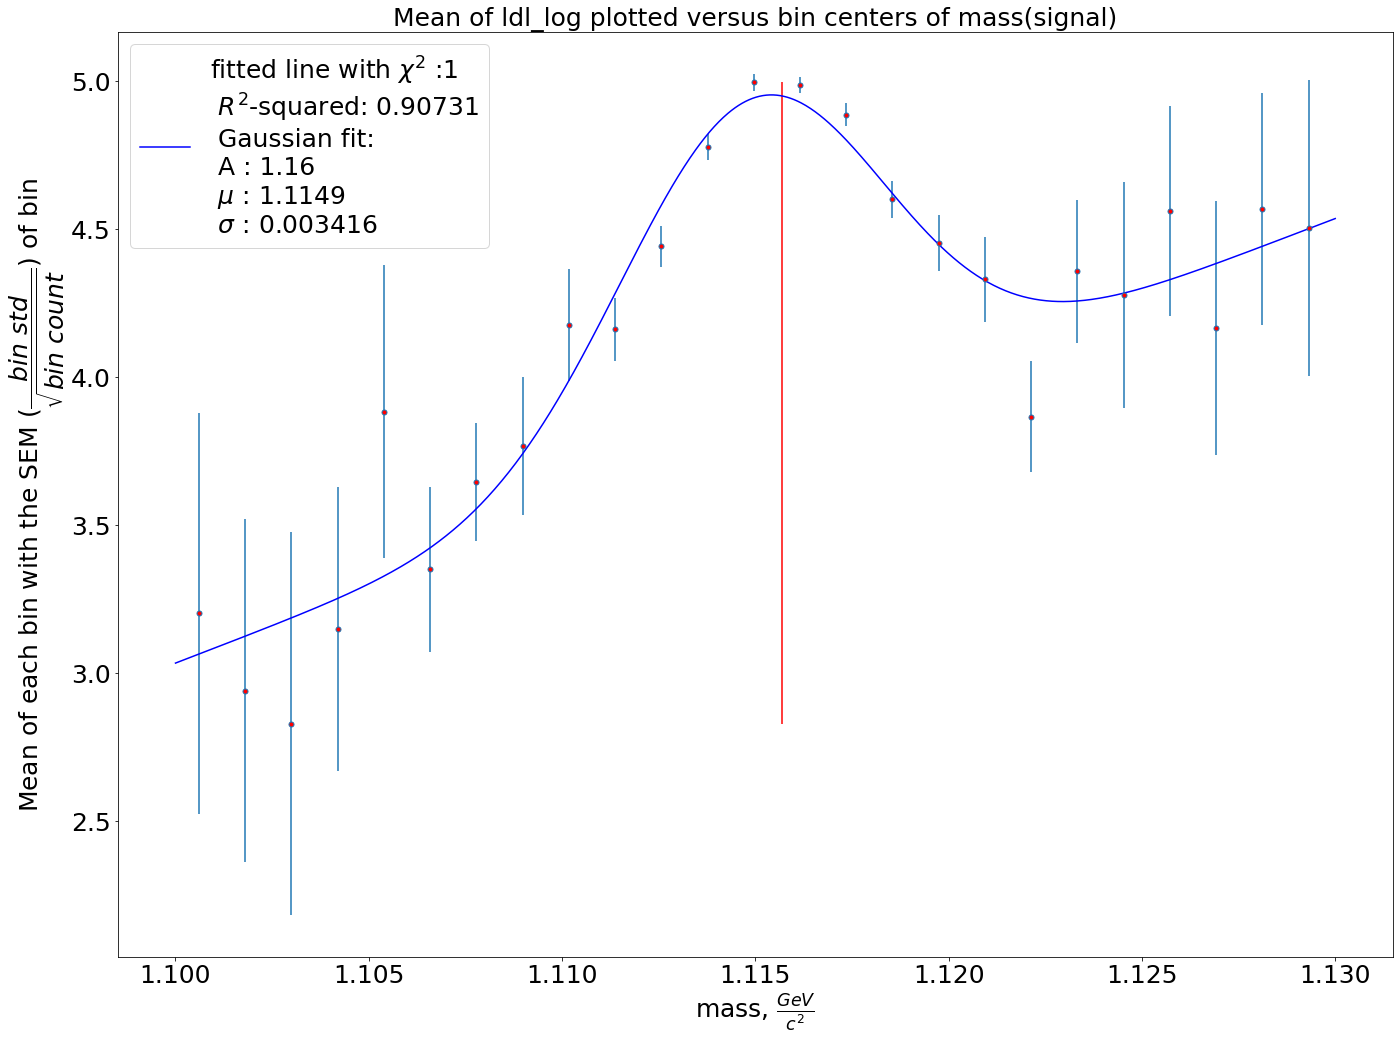

In [76]:
profile_plot_func(signal,'mass','ldl_log', 1, sign_bgr_mass_pdf, gaus)

Params:  [-3.26357699e+01  3.49731620e+01 -2.73125622e+00  1.11565863e+00
  4.67003121e-03]


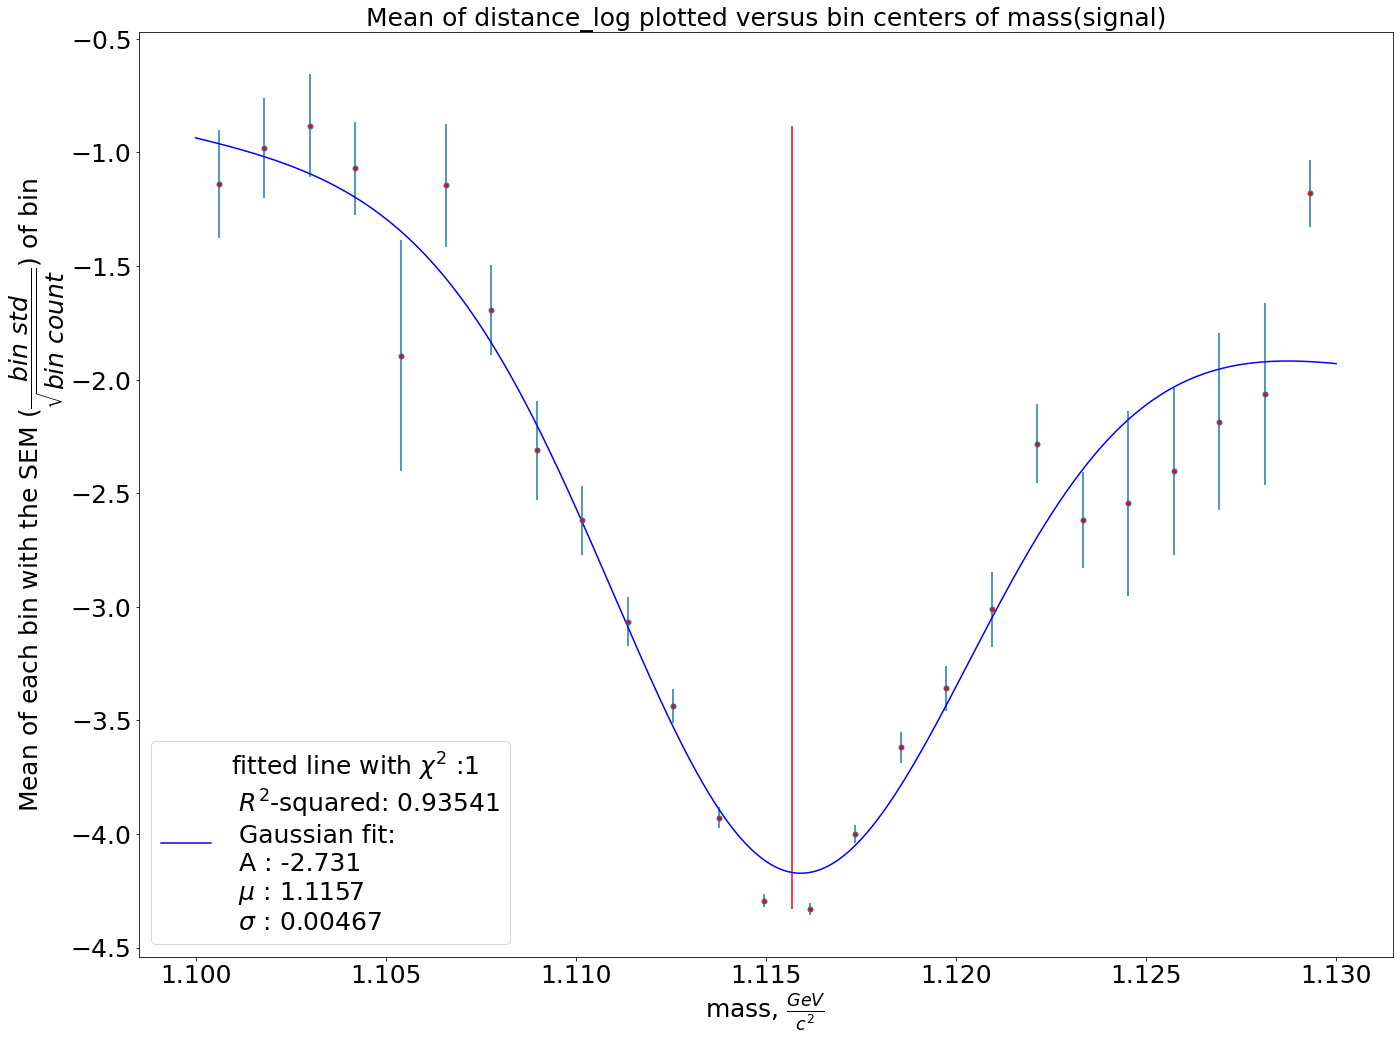

In [77]:
profile_plot_func(signal,'mass','distance_log', 1, sign_bgr_mass_pdf, gaus)

In [78]:
sign_bgr_mass_pdf.close()